In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare

import statsmodels.api as sm
from statsmodels.stats import weightstats as stests
from statsmodels.formula.api import ols
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

### Reading the dataset

In [2]:
df = pd.read_csv('Us_Ecommerce_Dataset.csv')
df.head(1)

,Transaction_id,customer_id,Date,Product,Gender,Device_Type,Country,State,City,Category,Customer_Login_type,Delivery_Type,Quantity,Transaction Start,Transaction_Result,Amount US$,Individual_Price_US$,Year_Month,Time
0,40170,1348959766,14-11-2013,Hair Band,Female,Web,United States,New York,New York City,Accessories,Member,one-day deliver,12,1,0,"6,910",576,13-Nov,22:35:51


## Data Pre-Processing

### Shape of the dataframe

In [3]:
df.shape

(65535, 19)

### Columns formatting

In [4]:
# Renaming columns for easy use
df.rename(columns={'Amount US$': 'Amount', 'Individual_Price_US$': 'Individual_Price',
                   'Transaction Start' : 'Transaction_Start'}, inplace=True)

# Removing space to the left and right of columns names to avoid errors
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.rstrip()

### Formatting datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Transaction_id       65535 non-null  int64 
 1   customer_id          65535 non-null  int64 
 2   Date                 65535 non-null  object
 3   Product              65535 non-null  object
 4   Gender               65535 non-null  object
 5   Device_Type          65535 non-null  object
 6   Country              65535 non-null  object
 7   State                65535 non-null  object
 8   City                 65535 non-null  object
 9   Category             65535 non-null  object
 10  Customer_Login_type  65535 non-null  object
 11  Delivery_Type        65535 non-null  object
 12  Quantity             65535 non-null  int64 
 13  Transaction_Start    65535 non-null  int64 
 14  Transaction_Result   65535 non-null  int64 
 15  Amount               65535 non-null  object
 16  Indi

Changing datatypes of `Amount` and `Individual Price` to `int` <br>
Changing datatypes of `Transaction_id` and `customer_id` to `object`

As for as datatypes of columns `Date` and `Time` is concerned, we will change it further down when neccessary.

In [6]:
df['Amount'] = df['Amount'].str.replace(',','')
df['Individual_Price'] = df['Individual_Price'].str.replace(',','')

df['Date'] = df['Date'] + df['Time']

df['Amount'] = df['Amount'].astype(int)
df['Individual_Price'] = df['Individual_Price'].astype(int)
df['Transaction_id'] = df['Transaction_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)

### Missing Values

In [7]:
df.isnull().sum()

Transaction_id         0
customer_id            0
Date                   0
Product                0
Gender                 0
Device_Type            0
Country                0
State                  0
City                   0
Category               0
Customer_Login_type    0
Delivery_Type          0
Quantity               0
Transaction_Start      0
Transaction_Result     0
Amount                 0
Individual_Price       0
Year_Month             0
Time                   0
dtype: int64

There are no missing values in the data

### Removing duplicate customer id's

In [8]:
Customers = df.groupby('customer_id')['State'].unique()
c = Customers.loc[Customers.apply(lambda x:len(x)>1)]
c

customer_id
1190165768      [New York, California]
1304414175    [California, Washington]
1364723379      [New York, Washington]
1454398544      [New York, Washington]
1454833377      [New York, Washington]
1497121840      [New York, Washington]
1506832198    [California, Washington]
1536263945      [New York, Washington]
1538313965      [New York, Washington]
1611232731    [California, Washington]
1764514840      [New York, Washington]
1781023755    [California, Washington]
2074849438    [Washington, California]
2075814986    [California, Washington]
2164428677      [New York, Washington]
2187409742    [California, Washington]
2198399940    [California, Washington]
Name: State, dtype: object

In [9]:
for i in range(len(c)):
    ind = df['customer_id'][df['customer_id'] == c.index[i]].index
    df = df.drop(ind)
    
Customers = df.groupby('customer_id')['State'].unique()
Customers.loc[Customers.apply(lambda x:len(x)>1)]

Series([], Name: State, dtype: object)

### Removal of Insignificant variables

Columns `Country`,`State`,`Transaction_Start` are not neccesary.<br>
Because Country is one value USA<br>
And Transaction_Start is one value (1)<br>
Also there is only one `City` corresponding to each state.
So we remove columns `Country` and `State` 
Removing `Time` column, since we combined Date and Time into a single column

In [10]:
df = df.drop(['Country','State','Transaction_Start','Time'], axis = 1)

## EDA

#### What is the gender ratio ?

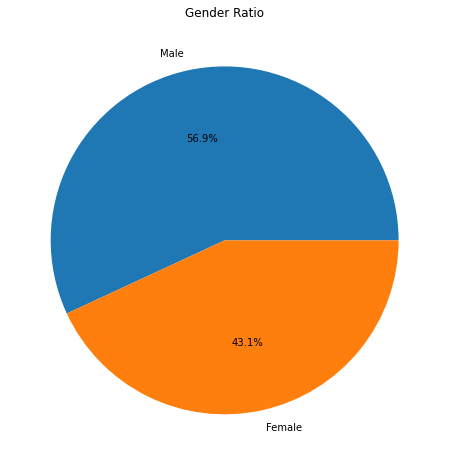

In [12]:
plt.figure(figsize = (15,8))
plt.pie(df['Gender'].value_counts(), labels = df['Gender'].value_counts().index, autopct = '%1.1f%%')
plt.title('Gender Ratio')
plt.show()

There are **56.9%** Male and **43.1%** Female in the dataset

#### What is the active number of customers each month ?

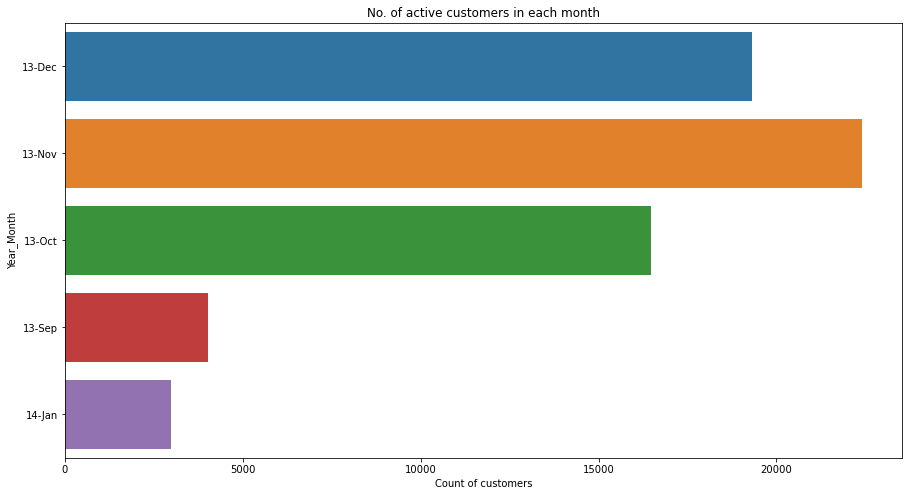

Year_Month
13-Dec    19321
13-Nov    22405
13-Oct    16477
13-Sep     4032
14-Jan     2995
Name: customer_id, dtype: int64

In [13]:
plt.figure(figsize = (15,8))
month_cohort = df.groupby('Year_Month')['customer_id'].nunique()

sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")
plt.show()

month_cohort

The month of November has the highest active customers

#### What are the top selling products by Quantity and by Value ?

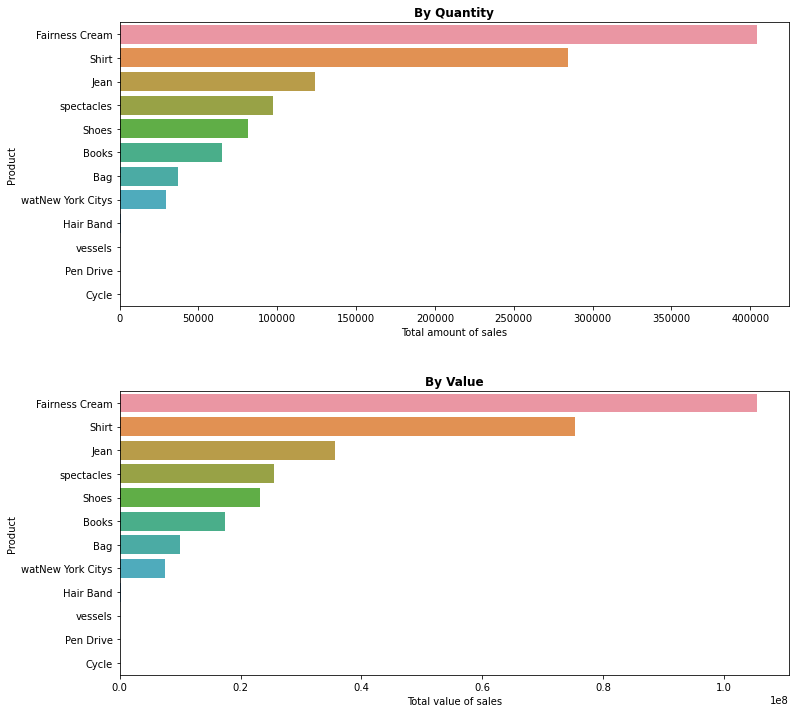

In [14]:
TopQuan = df.groupby('Product')['Quantity'].agg('sum').sort_values(ascending=False)
TopPrice = df.groupby('Product')['Amount'].agg('sum').sort_values(ascending=False)

fig,axs = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
plt.subplots_adjust(hspace = 0.3)


sns.barplot(x=TopQuan.values, y=TopQuan.index, ax= axs[0]).set(xlabel='Total amount of sales')
axs[0].set_title('By Quantity', size=12, fontweight = 'bold')
sns.barplot(x=TopPrice.values, y=TopPrice.index, ax= axs[1]).set(xlabel='Total value of sales')
axs[1].set_title('By Value', size=12, fontweight = 'bold')
plt.show()

**Fairness Cream** is the highest Selling product both by Quantity and Value

#### Relationship between Individual Price of Product and Quantity ?

<Figure size 1080x576 with 0 Axes>

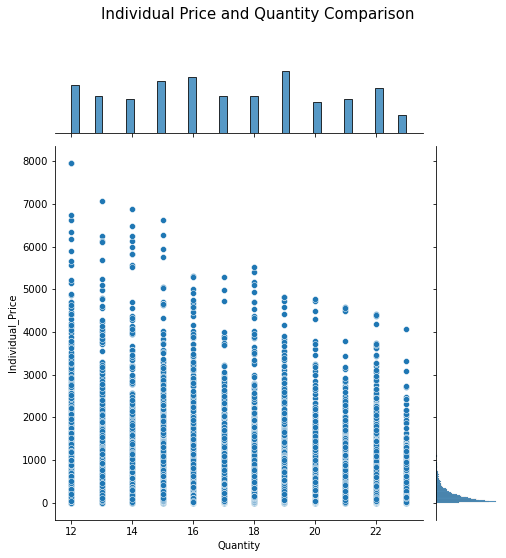

In [15]:
plt.figure(figsize = (15,8))
Corr = sns.jointplot(x="Quantity", y="Individual_Price", data = df[df.Individual_Price>0], height = 7)
Corr.fig.suptitle("Individual Price and Quantity Comparison", fontsize = 15, y = 1.1)
plt.show()

#### Which delivery type is most preferred by customers ?

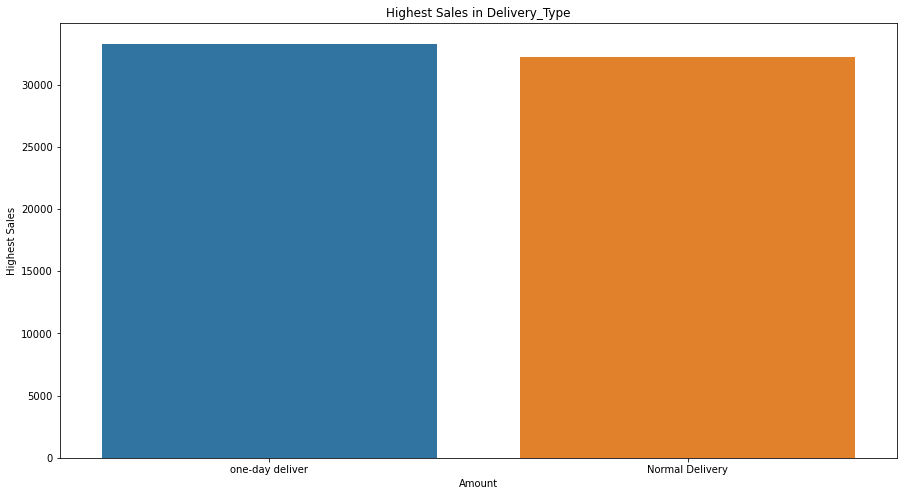

In [16]:
plt.figure(figsize = (15,8))
sns.countplot(df["Delivery_Type"])
plt.xlabel("Amount")
plt.ylabel("Highest Sales")
plt.title("Highest Sales in Delivery_Type")
plt.show()

**One-day Delivery** is most preferred by customers

#### What is the gender wise ratio in regards to the Customer login type?

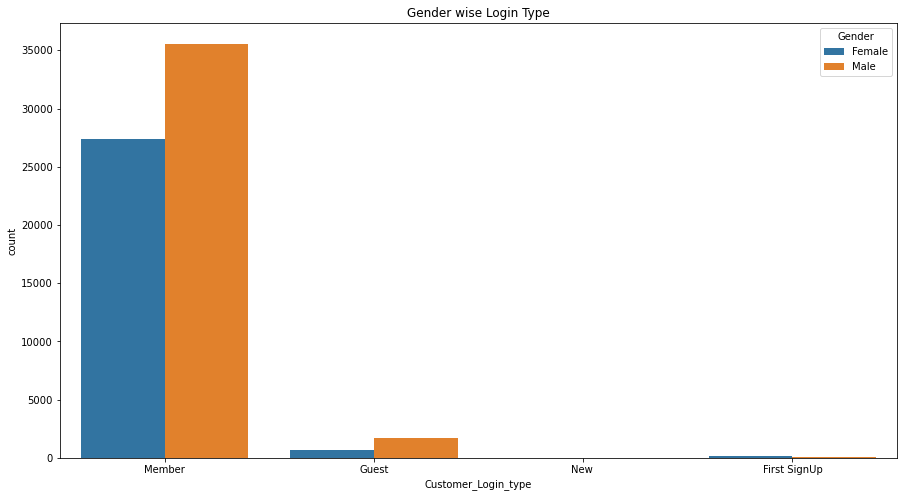

In [17]:
plt.figure(figsize = (15,8))
sns.countplot(x='Customer_Login_type', data= df, hue='Gender').set(title='Gender wise Login Type')
plt.show()

- Member Customers are mostly male
- First Sign Up Customers are mostly Female
- New Female Customers are more than Men

#### What is the category wise bifurcation of the products sold recorded for each month?

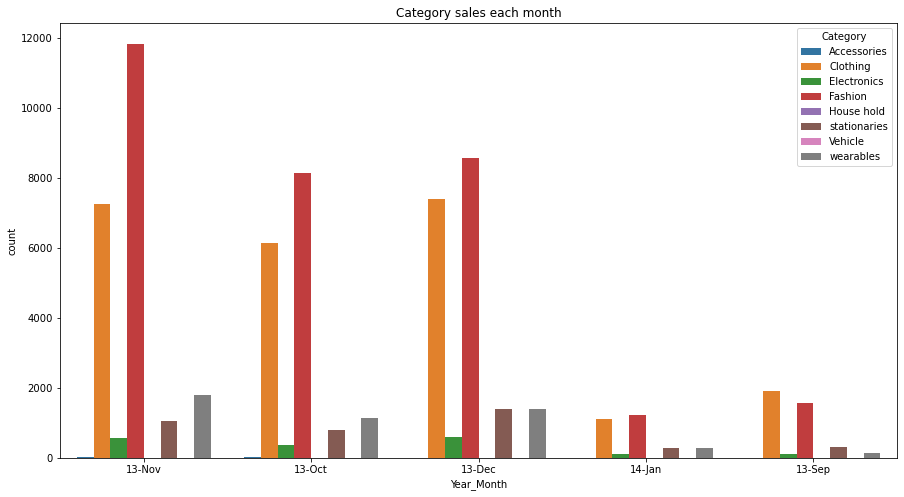

In [18]:
plt.figure(figsize = (15,8))
sns.countplot(x='Year_Month', data= df, hue='Category').set(title='Category sales each month')
plt.show()

- September - Clothing
- October - Fashion
- November - Fashion
- December - Fashion
- January - Fashion

#### Which Products sold highest in each month ?

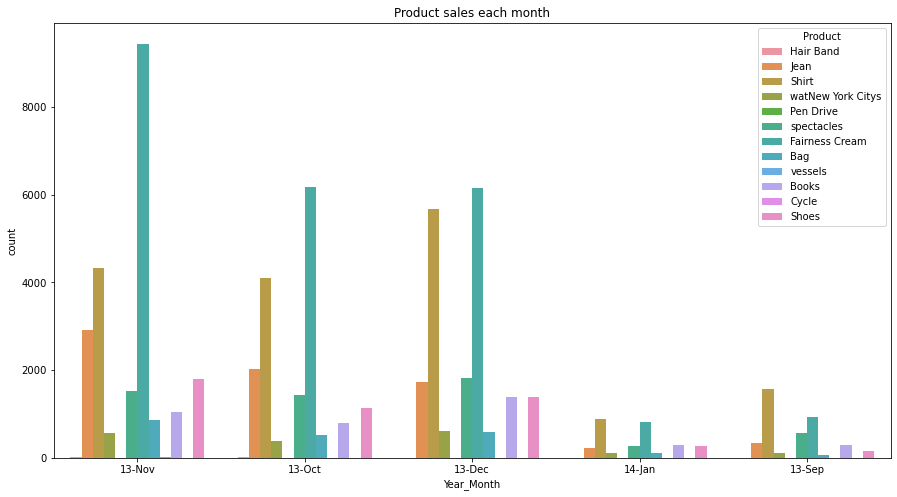

In [19]:
plt.figure(figsize = (15,8))
sns.countplot(x='Year_Month', data= df, hue='Product').set(title='Product sales each month')
plt.show()

- September - Shirt
- October - Fairness Cream
- November - Fairness Cream
- December - Fairness Cream
- January - Shirt

#### Which month has a surge in sales and which month has decline in sales ?

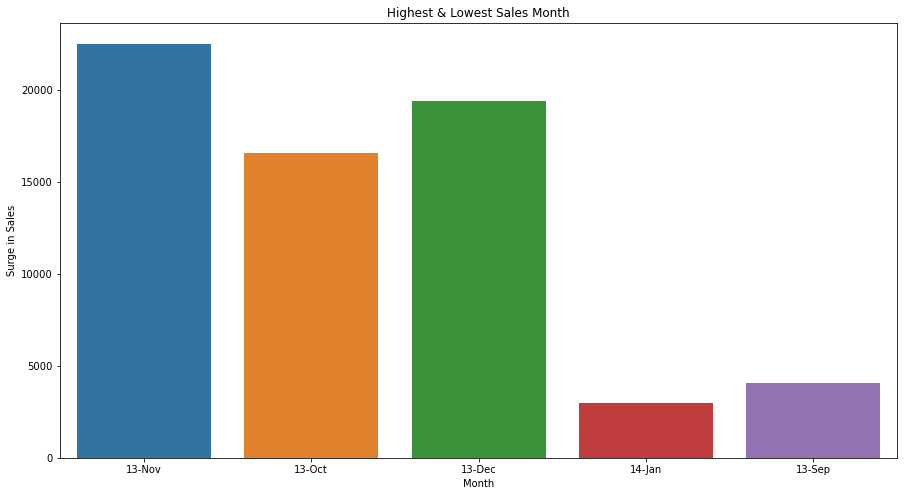

In [20]:
plt.figure(figsize = (15,8))
sns.countplot(df['Year_Month'])
plt.xlabel("Month")
plt.ylabel("Surge in Sales")
plt.title('Highest & Lowest Sales Month')
plt.show()

- Highest Sales Month : November (Beginning of holiday season)
- Lowest Sales Month : January (End of holiday season)

#### Gender wise analysis of product category bought?

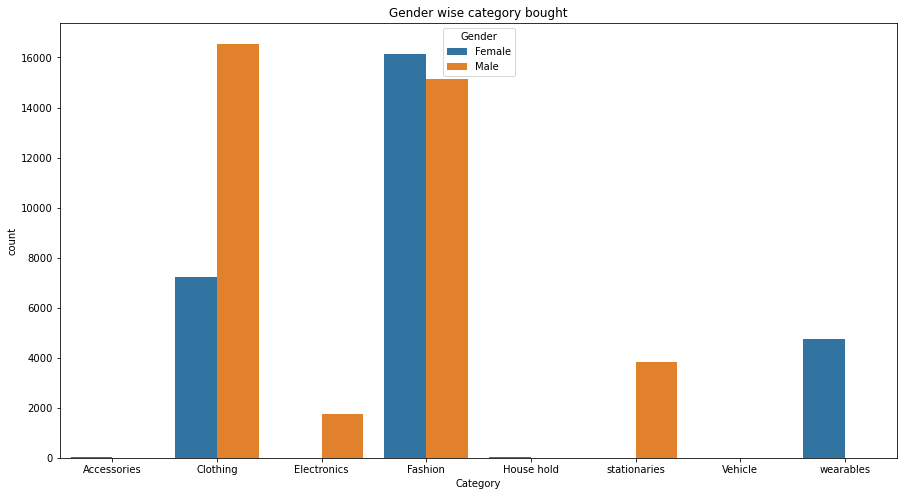

In [21]:
plt.figure(figsize = (15,8))
sns.countplot(x='Category', data= df, hue='Gender').set(title='Gender wise category bought')
plt.show()

- Most Preferred Category by Male : Clothing
- Least Preferred Categories by Male : Accessories, House hold, Vehicle, Wearables
- Most Preferred Category by Female : Fashion
- Least Preferred Categories by Female : Vehicle, Stationaries, Electronics

#### What type of delivery do guests mostly opt for ?

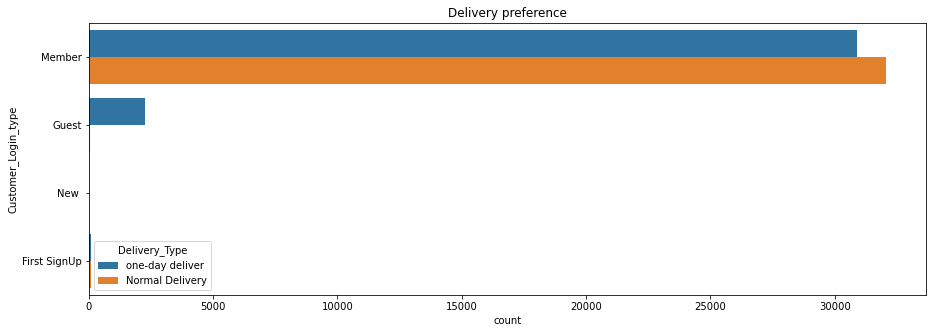

In [22]:
plt.figure(figsize= (15,5))

sns.countplot(y='Customer_Login_type', data= df, hue='Delivery_Type').set(title='Delivery preference')
plt.show()

Guest Login type customers prefer One-day Delivery

#### Which device type has maximum failed transactions ? 

In [23]:
d = df.groupby(['Device_Type','Transaction_Result'])[['Transaction_Result']].count()
d

Transaction_Result
Device_Type Transaction_Result                    
Mobile      0                                 1795
            1                                10744
Web         0                                 6893
            1                                46068

In [24]:
per_fail_mob = (d['Transaction_Result'][0] / d['Transaction_Result'][1]) * 100
per_fail_web = (d['Transaction_Result'][2] / d['Transaction_Result'][3]) * 100

print("Percentage of failed transactions in Mobile is",per_fail_mob)
print("Percentage of failed transactions in Web is",per_fail_web)

Percentage of failed transactions in Mobile is 16.70699925539836
Percentage of failed transactions in Web is 14.96266388816532


Web has high failed transactions than mobile<br>
But number of transactions are less in mobile.

#### What is the Retention Rate of customers in each month ?

In [25]:
retention_rate = round(month_cohort.pct_change(periods=1)*100,2)
retention_rate

Year_Month
13-Dec      NaN
13-Nov    15.96
13-Oct   -26.46
13-Sep   -75.53
14-Jan   -25.72
Name: customer_id, dtype: float64

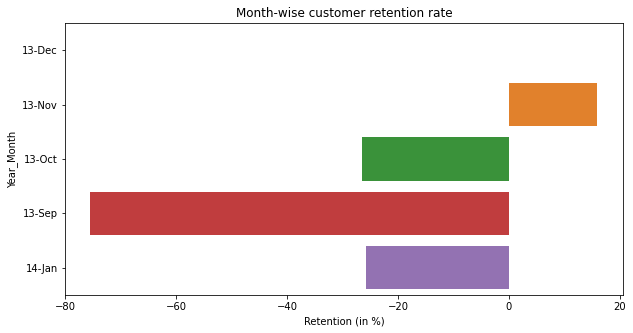

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(y = retention_rate.index, x = retention_rate.values);
plt.xlabel("Retention (in %)")
plt.title("Month-wise customer retention rate");

The retention rate is less than zero for all months except November. This signifies that the frequency of customers purchasing prodcts is very less

## Statistical significance of variables

Here we’ve performed the hypothesis testing with respect to the dependent variable with independent variables. 

Null Hypothesis (H0): The independent variable column and dependent variable column are related<br>
Alternate Hypothesis(H1): The independent variable column and the dependent variable column are not related.

The confidence level is 95% and so the alpha is 0.05

If the pvalue is less than alpha, we reject the null hypothesis <br>
If the pvalue is greater than alpha, we fail to reject the null hypothesis

`Transaction Result` is the dependent column, so checking the relationship of it with all other independent variables

#### Transaction Result and Product

In [23]:
model = sfa.ols('Transaction_Result~Product',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Product,11.0,23.821376,2.165580,18.879581,2.202824e-38
Residual,65488.0,7511.791693,0.114705,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Product are `related`.

#### Transaction Result and Gender

In [24]:
model = sfa.ols('Transaction_Result~Gender',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,5.269603,5.269603,45.834356,1.297672e-11
Residual,65498.0,7530.343466,0.114971,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Gender are `related`.

#### Transaction Result and Device Type

In [25]:
model = sfa.ols('Transaction_Result~Device_Type',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Device_Type,1.0,1.713682,1.713682,14.898362,0.000114
Residual,65498.0,7533.899386,0.115025,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Device Type are `related`.

#### Transaction Result and City

In [26]:
model = sfa.ols('Transaction_Result~City',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
City,2.0,40.258723,20.129362,175.897327,6.504062e-77
Residual,65497.0,7495.354346,0.114438,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and City are `related`.

#### Transaction Result and Category

In [27]:
model = sfa.ols('Transaction_Result~Category',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Category,7.0,10.685280,1.526469,13.285374,3.084309e-17
Residual,65492.0,7524.927788,0.114898,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Category are `related`.

#### Transaction Result and Customer Login Type

In [28]:
model = sfa.ols('Transaction_Result~Customer_Login_type',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Customer_Login_type,3.0,3.824119,1.274706,11.084773,2.857745e-07
Residual,65496.0,7531.788950,0.114996,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Customer Login type are `related`.

#### Transaction Result and Delivery Type

In [29]:
model = sfa.ols('Transaction_Result~Delivery_Type',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Delivery_Type,1.0,29.888482,29.888482,260.819027,1.476784e-58
Residual,65498.0,7505.724587,0.114595,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Delivery Type are `related`.

#### Transaction Result and Quantity

In [30]:
model = sfa.ols('Transaction_Result~Quantity',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Quantity,1.0,2.034724,2.034724,17.690179,0.000026
Residual,65498.0,7533.578345,0.115020,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Quantity are `related`.

#### Transaction Result and Amount

In [31]:
model = sfa.ols('Transaction_Result~Amount',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Amount,1.0,0.052798,0.052798,0.458911,0.498136
Residual,65498.0,7535.560271,0.115050,NaN,NaN


P-value is greater than 0.05. Hence we reject the null hypothesis.<br>
So Transaction Result and Amount are `not related`.

#### Transaction Result and Individual Price

In [32]:
model = sfa.ols('Transaction_Result~Individual_Price',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Individual_Price,1.0,0.949071,0.949071,8.25017,0.004076
Residual,65498.0,7534.663998,0.115037,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Transaction Result and Individual Price are `related`.

#### Additionally we determine if there is any statistical relationship between the independent variables

#### Amount and Individual Price US dollars

In [33]:
model = sfa.ols('Amount~Individual_Price',data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Individual_Price,1.0,2.950143e+12,2.950143e+12,20355.440491,0.0
Residual,65498.0,9.492719e+12,1.449314e+08,NaN,NaN


P-value is less than 0.05. Hence we accept the null hypothesis.<br>
So Amount and Individual Price are `related`.

#### Customer Login type and Delivery Type

Chi-square test of independence<br>

H0 : Customer Login and Delivery are independent<br>
Ha : Customer Login and Delivery are not independent

In [34]:
table = pd.crosstab(df['Customer_Login_type'],df['Delivery_Type'])

obs_val = table.values
obs_val

array([[   88,    99],
       [   47,  2268],
       [32060, 30902],
       [   16,    20]], dtype=int64)

In [35]:
chi2_val = np.abs(round(stats.chi2.isf(q = 0.05, df = 3), 4))

print('Critical value for chi-square test:', chi2_val)

test_stat, p, dof, expected_value = chi2_contingency(observed = obs_val, correction = False)

print("Test statistic:", test_stat)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected values:", expected_value)

Critical value for chi-square test: 7.8147
Test statistic: 2136.043180767123
p-value: 0.0
Degrees of freedom: 3
Expected values: [[9.19611756e+01 9.50388244e+01]
 [1.13844985e+03 1.17655015e+03]
 [3.09628852e+04 3.19991148e+04]
 [1.77037557e+01 1.82962443e+01]]


The above output shows that the chi-square test statistic is greater than 7.8147 and the p-value is less than 0.05, thus we reject the null hypothesis and conclude that the variables `Customer_Login_type` and `Delivery_Type` are `dependent`.

### Class Imbalance

Checking for imbalace in the dependent variable `Transaction_Result`

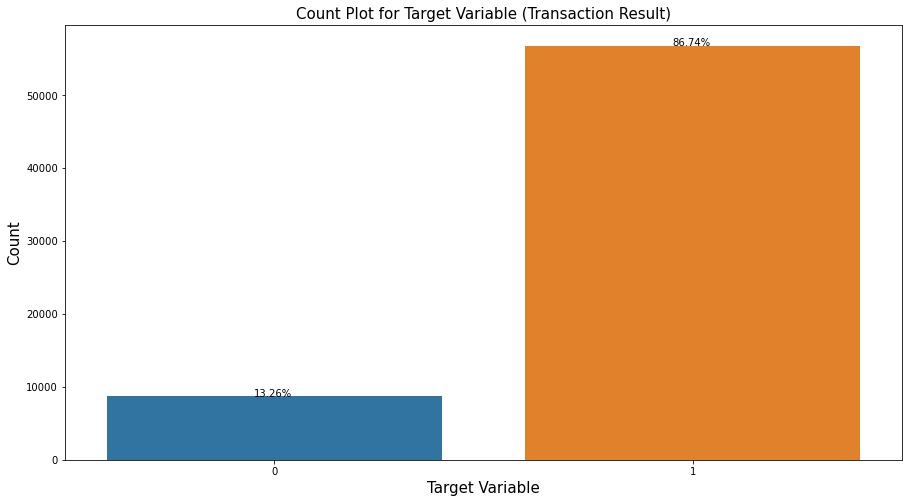

In [11]:
plt.figure(figsize = (15,8))

df_target = df['Transaction_Result'].copy()
sns.countplot(x = df_target)

plt.text(x = -0.05, y = df_target.value_counts()[0] + 1, 
         s = str(round((df_target.value_counts()[0])*100/len(df_target),2)) + '%')
plt.text(x = 0.95, y = df_target.value_counts()[1] +1, 
         s = str(round((df_target.value_counts()[1])*100/len(df_target),2)) + '%')

plt.title('Count Plot for Target Variable (Transaction Result)', fontsize = 15)
plt.xlabel('Target Variable', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

# to show the plot
plt.show()

Since the percentage of '0' is very less respective to '1'.<br>
It becomes clear that 'Transaction_Result' column is imbalanced.

So, we use Down-sampling technique to balance the data<br>
Down-sampling is the process of randomly removing observations from the majrity class in order to reinforce its signal.

In [12]:
df_major = df[df.Transaction_Result == 1]
df_minor = df[df.Transaction_Result == 0]
 
df_majority_downsampled = resample(df_major, replace=False, n_samples=8688, random_state=123) 
 
# Combine minority class with downsampled majority class
df_down = pd.concat([df_majority_downsampled, df_minor])
 
df_down = df_down.reset_index(drop=True)
df_down.Transaction_Result.value_counts()

1    8688
0    8688
Name: Transaction_Result, dtype: int64

## Outliers and its treatment

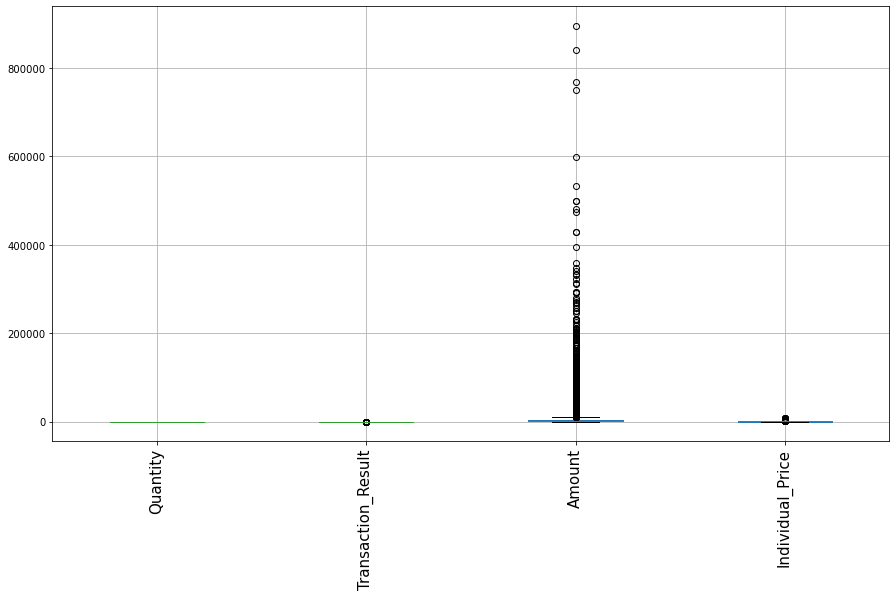

In [13]:
plt.figure(figsize = (15,8))

df.boxplot()
plt.xticks(rotation = 'vertical', fontsize = 15)
plt.show()

From the above plots, we notice that some of the variables have  outliers in the data. However, the exact location of these points is not precisely seen.

Let us use the IQR method to remove the outliers.

In [14]:
# calculate the first quartile
Q1 = df.quantile(0.25)

#calculate the third quartile
Q3 = df.quantile(0.75)

# The Interquartile Range (IQR) is defined as the difference between the third and first quartile
# calculate IQR
IQR = Q3 - Q1

# remove the outliers from the dataframe
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# reset the row index
df = df.reset_index(drop=True)

# check the shape of the data
df.shape

(50815, 15)

## Multi-collinearity

Multicollinearity (or collinearity) occurs when one independent variable in a regression model is linearly correlated with another independent variable.

Ultimately, multicollinearity makes prediction less accurate. For a given model, the underlying assumption is that the relationships among the predicting variables, as well as their relationship with the target variable, will be the same. However, when multicollinearity is present, this is less likely to be the case.

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable.

In [15]:
x = df.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data['feature'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
vif_data

,feature,VIF
0,Quantity,2.068324
1,Transaction_Result,60.652233
2,Amount,28.640496
3,Individual_Price,29.095603


An acceptable VIF is if it’s less than the max of 10 and 1/1-R²model<br>

Here we can see that the VIF values of 'Transaction Start','Amount' and 'Individual_Price' are far above the VIF threshold, indicating that there is a high collinearity between these variables

## Feature Engineering

In [16]:
df1 = df_down.copy()

In [17]:
num = df1.select_dtypes(include = [np.number])
cat  = df1.drop(['Transaction_id', 'customer_id', 'Date'],axis = 1).select_dtypes(include = [np.object])

### Encoding categorical variables

In [18]:
labelencoder_X = LabelEncoder()
cat['Product']      = labelencoder_X.fit_transform(cat['Product']) 
cat['Gender']  = labelencoder_X.fit_transform(cat['Gender']) 
cat['Device_Type']= labelencoder_X.fit_transform(cat['Device_Type']) 
cat['City']= labelencoder_X.fit_transform(cat['City'])
cat['Category']  = labelencoder_X.fit_transform(cat['Category']) 
cat['Customer_Login_type']  = labelencoder_X.fit_transform(cat['Customer_Login_type']) 
cat['Delivery_Type']     = labelencoder_X.fit_transform(cat['Delivery_Type']) 
cat['Year_Month']     = labelencoder_X.fit_transform(cat['Year_Month']) 

### Scaling the data

In [19]:
cat.head()

,Product,Gender,Device_Type,City,Category,Customer_Login_type,Delivery_Type,Year_Month
0,2,0,1,1,3,2,1,4
1,1,1,0,0,5,2,1,1
2,6,1,1,2,1,2,0,1
3,6,1,1,0,1,2,1,0
4,4,0,1,0,1,2,1,1


In [20]:
df_final = pd.concat([num,cat],axis = 1)

X = df_final.drop('Transaction_Result',axis = 1)
Y = df_final['Transaction_Result']

scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, columns = X.columns)

X.head()

,Quantity,Amount,Individual_Price,Product,Gender,Device_Type,City,Category,Customer_Login_type,Delivery_Type,Year_Month
0,1.453511,-0.296293,-0.577513,-0.830372,-1.118512,0.495482,-0.352815,0.254091,0.179043,1.049206,2.583064
1,0.847992,-0.233079,-0.458864,-1.225794,0.894045,-2.018238,-1.437863,1.596881,0.179043,1.049206,-0.207609
2,0.545232,0.335849,0.670681,0.751315,0.894045,0.495482,0.732232,-1.088698,0.179043,-0.953101,-0.207609
3,-0.665807,-0.185668,-0.299873,0.751315,0.894045,0.495482,-1.437863,-1.088698,0.179043,1.049206,-1.137833
4,-0.363047,-0.075296,-0.057828,-0.039529,-1.118512,0.495482,-1.437863,-1.088698,0.179043,1.049206,-0.207609


### Train - Test Split

In [21]:
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size = 0.3)

print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (12163, 12)
y_train (12163,)
X_test (5213, 12)
y_test (5213,)


## Model Creation

In [22]:
# Generalised function to generate report

def get_report(model,x,y):
    pred = model.predict(x)
    print("Confusion matrix")
    print(confusion_matrix(y, pred))
    print("Accuracy score :",round((accuracy_score(y, pred) *100),2))
    print("AUC score :",round((roc_auc_score(y, pred) * 100),2))

In [23]:
def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)

### Logistic Regression

In [25]:
logmodel = LogisticRegression() 
logreg = logmodel.fit(X_train,y_train)

print("Report for test data \n")
get_report(logreg, X_test, y_test)
print()
print("Report for train data \n")
get_report(logreg, X_train, y_train)

Report for test data 

Confusion matrix
[[1696  899]
 [1385 1233]]
Accuracy score : 56.19
AUC score : 56.23

Report for train data 

Confusion matrix
[[3979 2114]
 [3209 2861]]
Accuracy score : 56.24
AUC score : 56.22


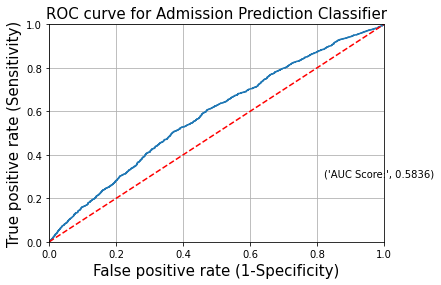

In [26]:
plot_roc(logreg)

### Decision Tree

In [27]:
dtree = DecisionTreeClassifier(criterion='gini')
dectree = dtree.fit(X_train, y_train)

print("Report for test data \n")
get_report(dectree, X_test, y_test)
print()
print("Report for train data \n")
get_report(dectree, X_train, y_train)

Report for test data 

Confusion matrix
[[1439 1156]
 [1271 1347]]
Accuracy score : 53.44
AUC score : 53.45

Report for train data 

Confusion matrix
[[5971  122]
 [ 323 5747]]
Accuracy score : 96.34
AUC score : 96.34


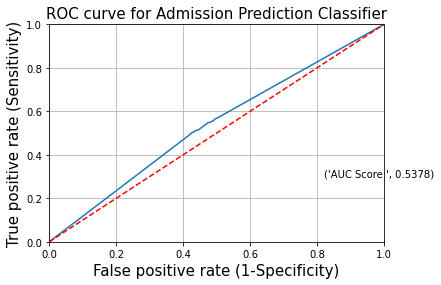

In [28]:
plot_roc(dectree)

### Tuning Hyperparameters GridSearchCV

In [70]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"],
                     'min_samples_split': range(2,10),
                     'min_samples_leaf': range(1,10),
                     'max_leaf_nodes': range(1, 10)}]
 
decision_tree_classification = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         param_grid = tuned_paramaters, 
                         cv = 5)

tree_grid_model = tree_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_samples_leaf': 5, 'min_samples_split': 2} 



In [72]:
dt_model = DecisionTreeClassifier(criterion = tree_grid_model.best_params_.get('criterion'),
                                  max_depth = tree_grid_model.best_params_.get('max_depth'),
                                  max_features = tree_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = tree_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = tree_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = tree_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
dt_model = dt_model.fit(X_train, y_train)

print("Report for test data \n")
get_report(dt_model, X_test, y_test)
print()
print("Report for train data \n")
get_report(dt_model, X_train, y_train)

Report for test data 

Confusion matrix
[[1082 1513]
 [ 681 1937]]
Accuracy score : 57.91
AUC score : 57.84

Report for train data 

Confusion matrix
[[2458 3635]
 [1579 4491]]
Accuracy score : 57.13
AUC score : 57.16


### Random Forest

In [74]:
ran_model = RandomForestClassifier(criterion='gini')
ranfor = ran_model.fit(X_train, y_train)

print("Report for test data \n")
get_report(ranfor, X_test, y_test)
print()
print("Report for train data \n")
get_report(ranfor, X_train, y_train)

Report for test data 

Confusion matrix
[[1443 1152]
 [1230 1388]]
Accuracy score : 54.31
AUC score : 54.31

Report for train data 

Confusion matrix
[[5859  234]
 [ 211 5859]]
Accuracy score : 96.34
AUC score : 96.34


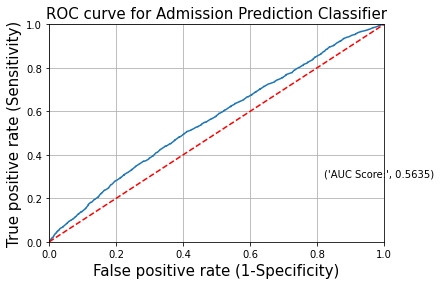

In [76]:
plot_roc(ranfor)

### Tuning Hyperparameters GridSearchCV

In [75]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 
random_forest_classification = RandomForestClassifier(random_state = 10)

rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5)
rf_grid_model = rf_grid.fit(X_train, y_train)

print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 11, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 50} 



In [77]:
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_model.fit(X_train, y_train)

print("Report for test data \n")
get_report(rf_model, X_test, y_test)
print()
print("Report for train data \n")
get_report(rf_model, X_train, y_train)

Report for test data 

Confusion matrix
[[1673  922]
 [1290 1328]]
Accuracy score : 57.57
AUC score : 57.6

Report for train data 

Confusion matrix
[[3919 2174]
 [2979 3091]]
Accuracy score : 57.63
AUC score : 57.62


### Ada Boost

In [57]:
ada_model = AdaBoostClassifier(n_estimators = 40, random_state = 10)
ada = ada_model.fit(X_train, y_train)

print("Report for test data \n")
get_report(ada, X_test, y_test)
print()
print("Report for train data \n")
get_report(ada, X_train, y_train)

Report for test data 

Confusion matrix
[[1623  972]
 [1207 1411]]
Accuracy score : 58.2
AUC score : 58.22

Report for train data 

Confusion matrix
[[3800 2293]
 [2771 3299]]
Accuracy score : 58.37
AUC score : 58.36


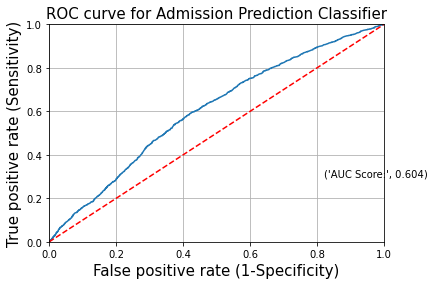

In [58]:
plot_roc(ada)

### XGBoost

In [32]:
xgb = XGBClassifier()
xgb_model = xgb.fit(X_train, y_train)

print("Report for test data \n")
get_report(xgb_model, X_test, y_test)
print()
print("Report for train data \n")
get_report(xgb_model, X_train, y_train)

Report for test data 

Confusion matrix
[[1437 1158]
 [1199 1419]]
Accuracy score : 54.79
AUC score : 54.79

Report for train data 

Confusion matrix
[[4637 1456]
 [1526 4544]]
Accuracy score : 75.48
AUC score : 75.48


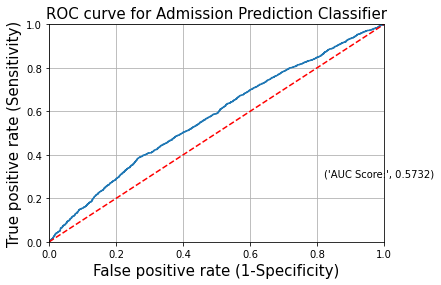

In [33]:
plot_roc(xgb_model)

### Gradient Boosting

In [34]:
gbk = GradientBoostingClassifier()
gbk_model = gbk.fit(X_train, y_train)

print("Report for test data \n")
get_report(gbk_model, X_test, y_test)
print()
print("Report for train data \n")
get_report(gbk_model, X_train, y_train)

Report for test data 

Confusion matrix
[[1560 1035]
 [1150 1468]]
Accuracy score : 58.09
AUC score : 58.09

Report for train data 

Confusion matrix
[[3769 2324]
 [2503 3567]]
Accuracy score : 60.31
AUC score : 60.31


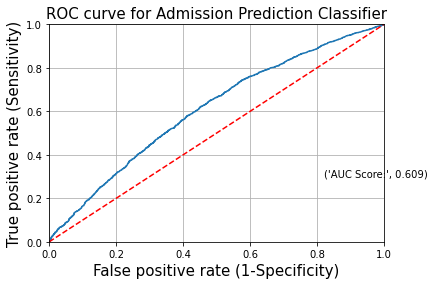

In [35]:
plot_roc(gbk_model)

**Of all the Classification models - `Ada Boost classifier` gave the best accuracy of 58% without over-fitting**

### Important Features

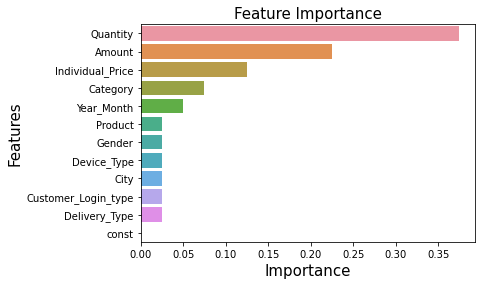

In [36]:
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the average gain 
important_features = pd.DataFrame({'Features': X_train.columns, 
                                   'Importance': ada.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

In [59]:
important_features

,Features,Importance
1,Quantity,0.375
2,Amount,0.225
3,Individual_Price,0.125
8,Category,0.075
11,Year_Month,0.050
4,Product,0.025
5,Gender,0.025
6,Device_Type,0.025
7,City,0.025
9,Customer_Login_type,0.025


### Cross Validation

#### KFold

In [37]:
kf = KFold(n_splits = 10)

In [38]:
def get_score(model, X_train_k, X_test_k, y_train_k, y_test_k):
    model.fit(X_train_k, y_train_k)                                   
    return model.score(X_test_k, y_test_k) 

In [39]:
# create an empty list to store the scores
scores = []

for train_index, test_index in kf.split(X_train):
    X_train_k, X_test_k, y_train_k, y_test_k = X_train.iloc[train_index], X_train.iloc[test_index], \
                                               y_train.iloc[train_index], y_train.iloc[test_index]
   
    # call the function 'get_scores()' and append the scores in the list 'scores'
    scores.append(get_score(AdaBoostClassifier(n_estimators = 40, random_state = 10),
                            X_train_k, X_test_k, y_train_k, y_test_k)) 
    
# print all scores
print('All scores: ', scores)
print("\nMinimum score obtained: ", round(min(scores), 4))
print("Maximum score obtained: ", round(max(scores), 4))
print("Average score obtained: ", round(np.mean(scores), 4))

All scores:  [0.5768282662284305, 0.5702547247329499, 0.580115036976171, 0.5575657894736842, 0.5723684210526315, 0.5699013157894737, 0.5699013157894737, 0.5740131578947368, 0.5674342105263158, 0.5912828947368421]

Minimum score obtained:  0.5576
Maximum score obtained:  0.5913
Average score obtained:  0.573


#### Cross Val Score

In [40]:
scores = cross_val_score(estimator = AdaBoostClassifier(n_estimators = 40, random_state = 10), 
                         X = X_train, y = y_train, cv = 5)

print('All scores: ', scores)
print("\nMinimum score obtained: ", round(min(scores), 4))
print("Maximum score obtained: ", round(max(scores), 4))
print("Average score obtained: ", round(np.mean(scores), 4))

All scores:  [0.5729552  0.57336621 0.57953144 0.58100329 0.56784539]

Minimum score obtained:  0.5678
Maximum score obtained:  0.581
Average score obtained:  0.5749


## Customer Segmentation

In [53]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y%H:%M:%S')

In [54]:
# monetary analysis - total amount spent by each customer

monetary = df.groupby('customer_id').sum()['Amount'].reset_index()
monetary.head()

,customer_id,Amount
0,1152937741,0
1,1152948204,800
2,1152980810,819
3,1153004167,7150
4,1153087279,1


In [55]:
# frequency analysis - how many times the customer bought products

frequency = df.groupby(['customer_id'])['Transaction_id'].count().reset_index()
frequency.head()

,customer_id,Transaction_id
0,1152937741,1
1,1152948204,1
2,1152980810,1
3,1153004167,1
4,1153087279,1


In [56]:
# recency analysis
# reference date for calculating recency as last transaction day in data + 1 day

ref_day = max(df['Date']) + timedelta(days=1)
df['days_to_last_order'] = (ref_day - df['Date']).dt.days

recency = df.groupby('customer_id')['days_to_last_order'].min().reset_index()
recency.head()

,customer_id,days_to_last_order
0,1152937741,41
1,1152948204,54
2,1152980810,50
3,1153004167,105
4,1153087279,54


In [57]:
# rfm data

rf = pd.merge(recency, frequency,  on='customer_id', how='inner')
rfm = pd.merge(rf, monetary, on='customer_id', how='inner')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,1152937741,41,1,0
1,1152948204,54,1,800
2,1152980810,50,1,819
3,1153004167,105,1,7150
4,1153087279,54,1,1


In [58]:
# rfm segments

rfm['Recency_labels'] = pd.cut(rfm['Recency'], bins = 3, labels=['New','Medium','Old'])

rfm['Frequency_labels'] = pd.cut(rfm['Frequency'], bins = 3, labels=['Low','Medium','High'])

rfm['Monetary_labels'] = pd.cut(rfm['Monetary'], bins = 3, labels=['Small','Medium','large'])

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_labels,Frequency_labels,Monetary_labels
0,1152937741,41,1,0,Medium,Low,Small
1,1152948204,54,1,800,Medium,Low,Small
2,1152980810,50,1,819,Medium,Low,Small
3,1153004167,105,1,7150,Old,Low,Small
4,1153087279,54,1,1,Medium,Low,Small


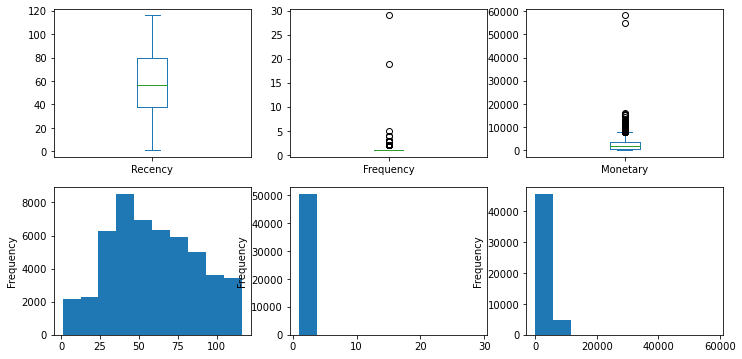

In [59]:
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    rfm[feature].plot(kind='box')
    plt.subplot(2,3,i+1+3)
    rfm[feature].plot(kind='hist')

In [60]:
# Outliers

rfm = rfm[(rfm['Frequency'] < 6) & (rfm['Monetary'] < 12000)]
rfm.shape

(50494, 7)

### Transformation

In [61]:
# log transformation

rfm_log = pd.DataFrame()
rfm_log['Recency'] = np.log(rfm['Recency'])
rfm_log['Frequency'] = np.log(rfm['Frequency'])
rfm_log['Monetary'] = np.log(rfm['Monetary'] - rfm['Monetary'].min()+1)

### Scaling the data

In [62]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_scaled.head()

,Recency,Frequency,Monetary
0,-0.314249,-0.06718,-2.412751
1,0.097550,-0.06718,0.066188
2,-0.017523,-0.06718,0.074880
3,1.091831,-0.06718,0.877865
4,0.097550,-0.06718,-2.155750


### K-means Clustering

In [63]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [64]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

### Optimal Clusters - Elbow plot

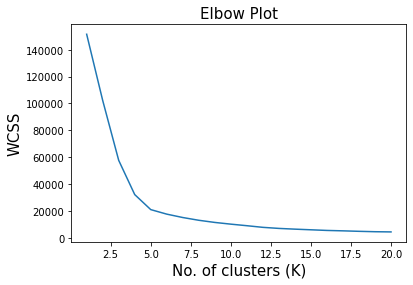

In [65]:
wcss = []

for num_clusters in range(1,21):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(range(1,21),wcss)

plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)

# display the plot
plt.show()

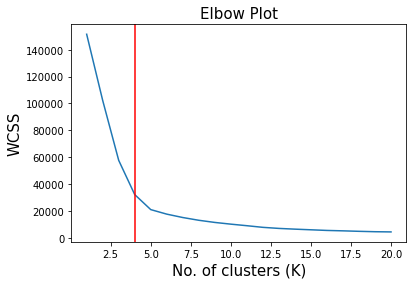

In [66]:
# visualize the elbow plot to get the optimal value of K
plt.plot(range(1,21), wcss)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)

# plot a vertical line at the elbow
plt.axvline(x = 4, color = 'red')

# display the plot
plt.show()

**Optimal Clusters is 4**

In [67]:
n_clusters = [2, 3, 4, 5]

for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.8909737715239446)
For 3 clusters the silhouette score is 0.6305605321065514)
For 4 clusters the silhouette score is 0.6354921822654809)
For 5 clusters the silhouette score is 0.4854669368654456)


In [68]:
# build a K-Means model with 4 clusters
new_clusters = KMeans(n_clusters = 4, random_state = 10)

# fit the model
new_clusters.fit(rfm_scaled)

# append the cluster label for each point in the dataframe 'df_cust'
rfm['Cluster'] = new_clusters.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_labels,Frequency_labels,Monetary_labels,Cluster
0,1152937741,41,1,0,Medium,Low,Small,0
1,1152948204,54,1,800,Medium,Low,Small,1
2,1152980810,50,1,819,Medium,Low,Small,1
3,1153004167,105,1,7150,Old,Low,Small,1
4,1153087279,54,1,1,Medium,Low,Small,0


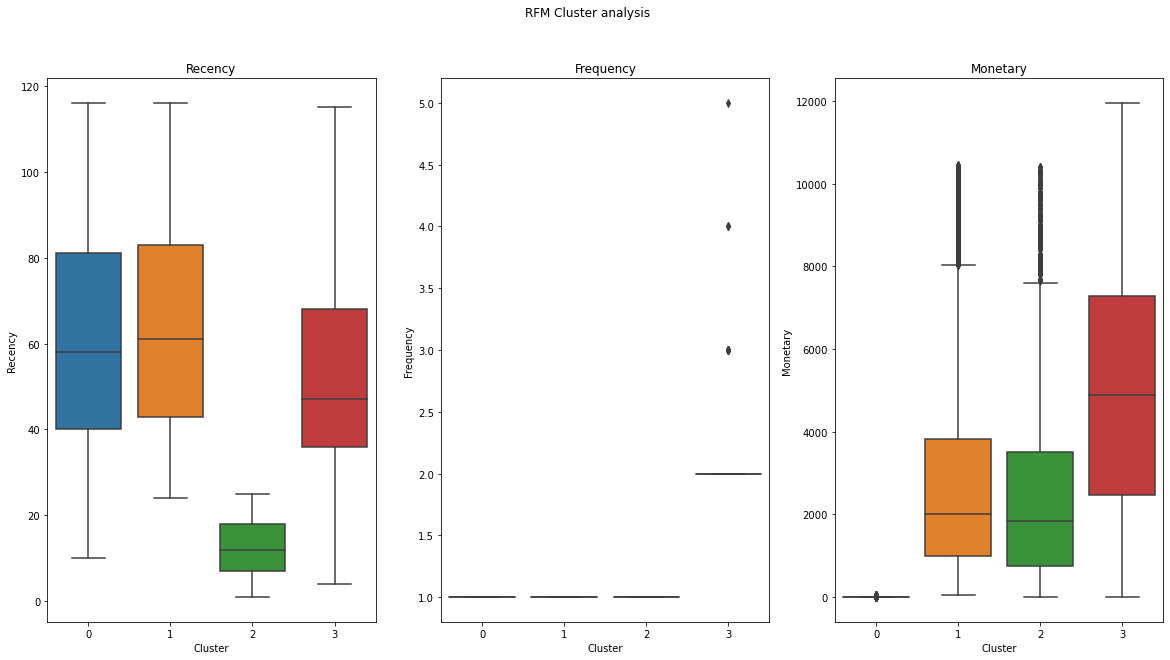

In [69]:
plt.figure(figsize = (20,10))

plt.suptitle('RFM Cluster analysis')

plt.subplot(1,3,1)
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency')

plt.subplot(1,3,2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency')

plt.subplot(1,3,3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary')

plt.show()

**Inference :**
- Cluster Group 3 are the most frequent buyers, spending high amount and recently placing orders so they are the most important  customers from business point of view.
- Cluster 1 and 2 has medium Recency and Monetary but lacks in frequency,focusing on this group and increasing their frequency may generate high sales.
- Cluster 0 has the least score in all three and are least important.